#8.1 Engine lifetime with RNNs

In this exercise, you will develop a Recurrent Neural Network capable of estimating the lifetime of engines. Your final submission should include a link to your google collab notebook, and a pdf adressing the questions asked in the task. You can use this template to get started: https://colab.research.google.com/drive/1HeCd0EIGTEbAAVNgyWeMKMgCejKcA031#scrollTo=A_dA-aOjvbza

The paper that can help you with the exercises can be found here:\
Wang, Y., Zhao, Y. & Addepalli, S. Practical Options for Adopting Recurrent Neural Network and Its Variants on Remaining Useful Life Prediction. Chin. J. Mech. Eng. 34, 69 (2021). https://doi.org/10.1186/s10033-021-00588-x

##Experimental Scenario

The data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. Therefore, the labels for the training data set have to be determined from the remaining time steps. In the test set, the time series ends some time prior to system failure. The objective of the exercise is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided is a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1\.	unit number\
2\.	time, in cycles\
3\.	operational setting 1\
4\.	operational setting 2\
5\.	operational setting 3\
6\.	sensor measurement  1\
7\.	sensor measurement  2\
... \
26\.	sensor measurement  21

For this exercise we only consider the FD001 data set.

Data Set: FD001\
Train trjectories: 100\
Test trajectories: 100\
Conditions: ONE (Sea Level)\
Fault Modes: ONE (HPC Degradation)




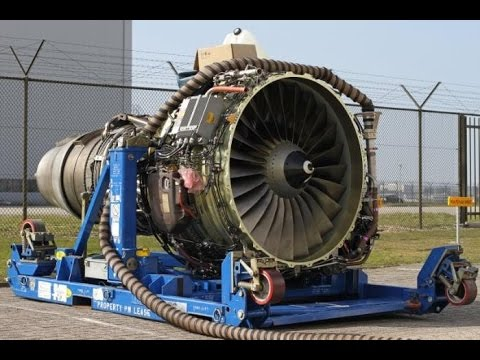



Y. Dwivedi, Predicting Engine Failure using C-MAPSS data, 2018 (https://yajasd.github.io/2018/06/04/Predicting-Engine-Failure/)

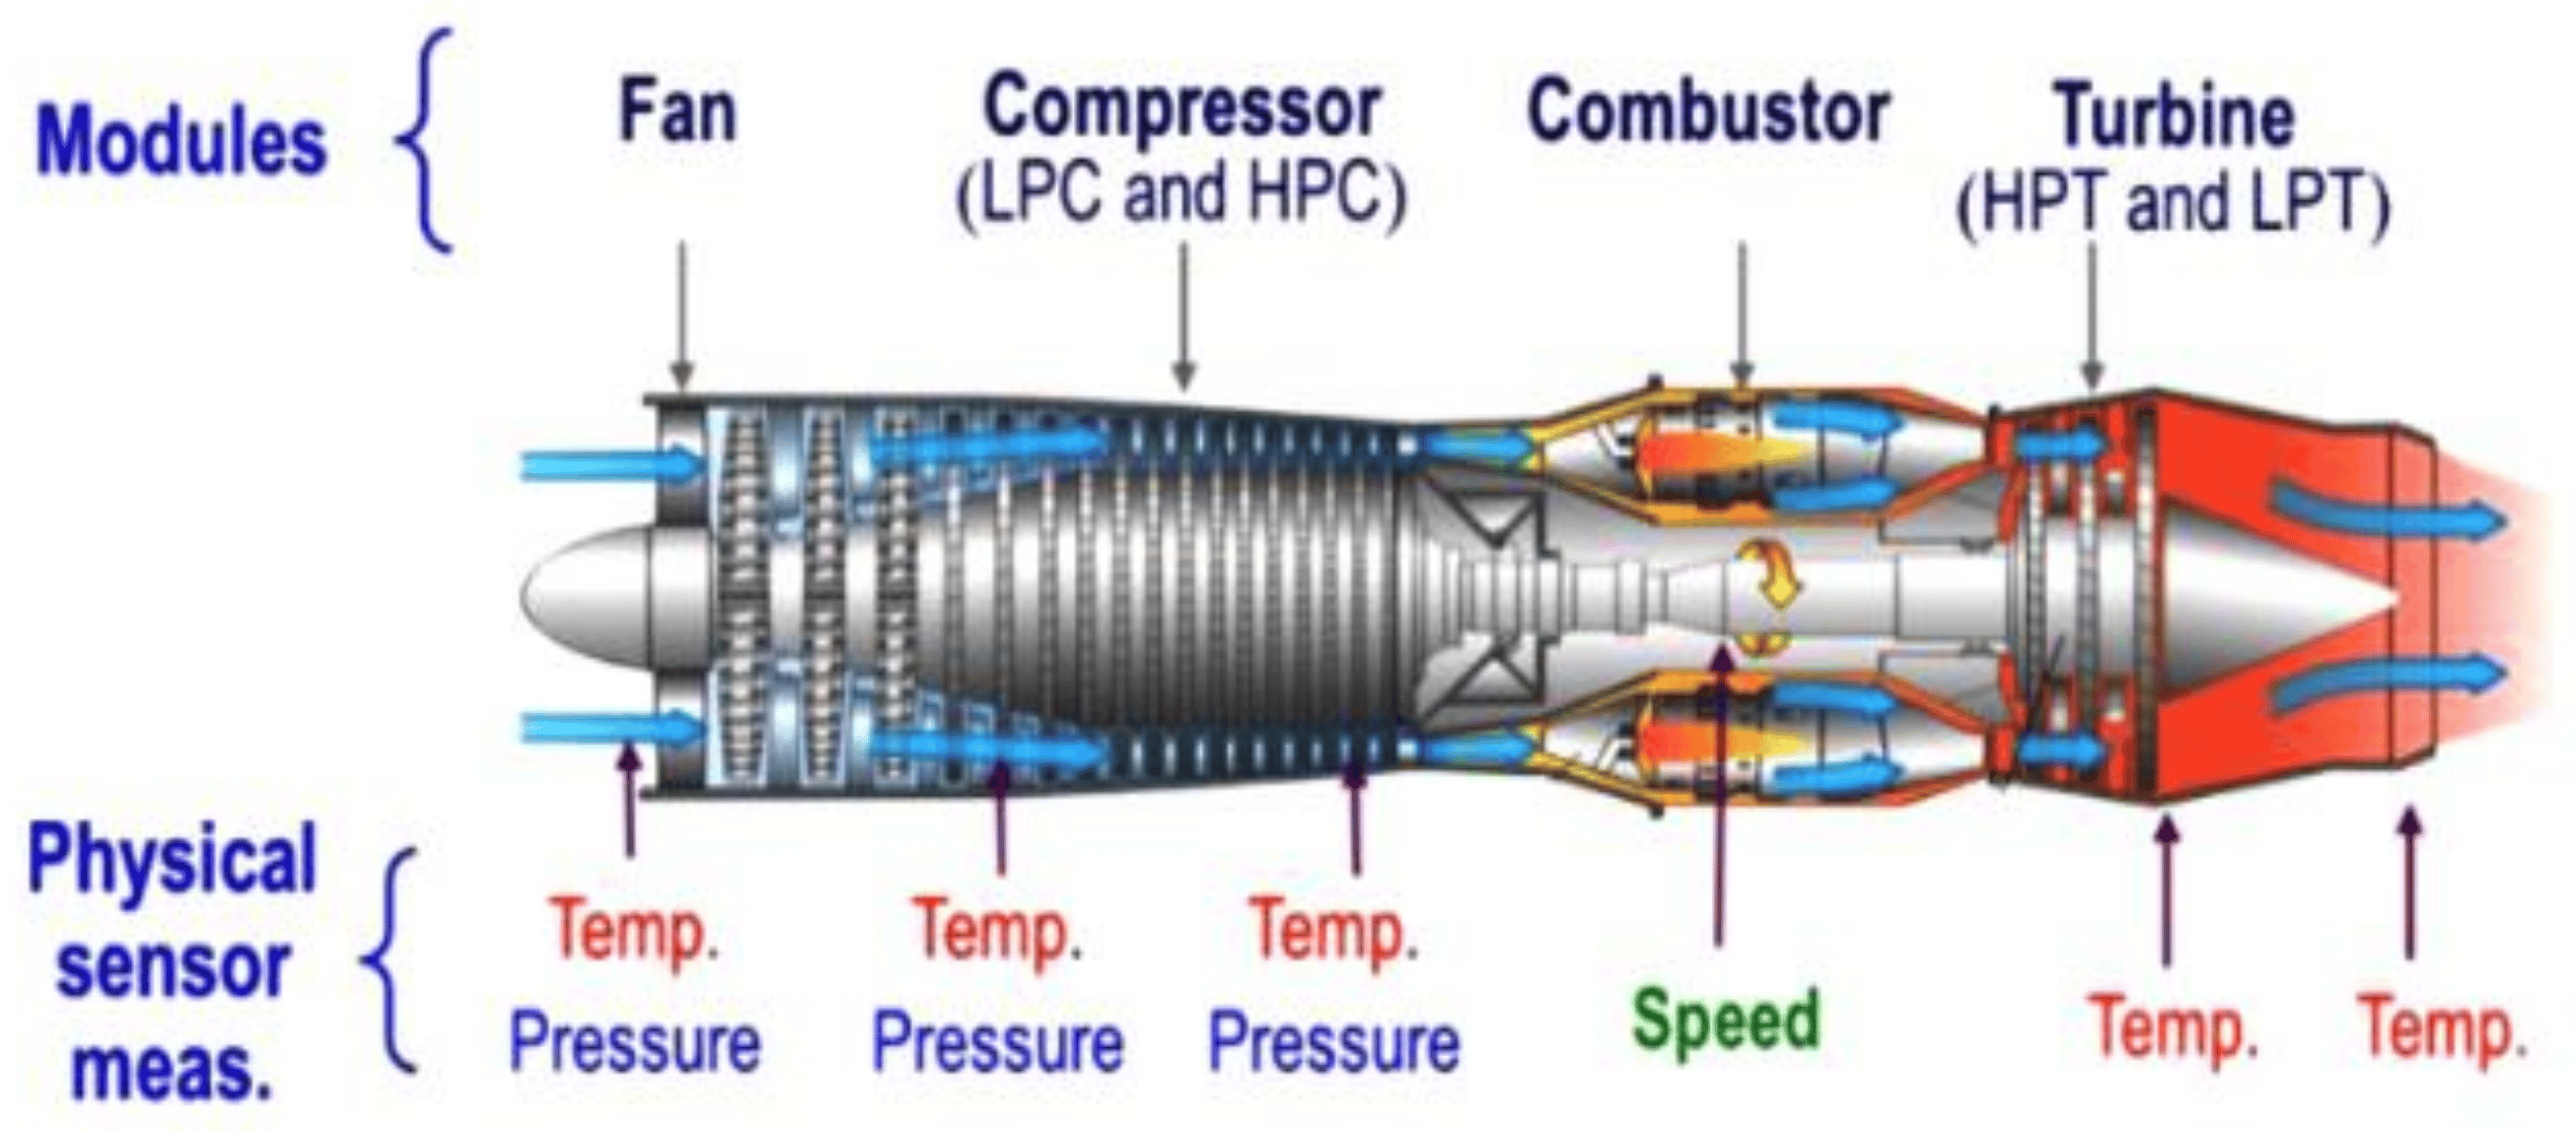


Muneer, A.; Taib, S.M.; Naseer, S.; Ali, R.F.; Aziz, I.A. Data-Driven Deep Learning-Based Attention Mechanism for Remaining Useful Life Prediction: Case Study Application to Turbofan Engine Analysis. Electronics 2021, 10, 2453. https://doi.org/10.3390/electronics10202453

## Exercises

The data structure of the input data is the most important thing when training a RNN. Make sure you understand the format of the input data.


1.   Normalize the input data. It can be useful to use helper functions instead of manually implementing the normaliztion. Here, you get to know the `sklearn` package. Please use the functions `sklearn.preprocessing.StandardScaler().fit()` and `sklearn.preprocessing.StandardScaler().transform()`. For additional help see the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and this tutorial (https://www.youtube.com/watch?v=ZddUwo4R5ug).

2.   Make several plots to understand the input data for all, and for a single unit. How do the plots change after the normalization? Also plot the labels for the training data.

3.   Explain in your notes what the for-loop in section 10 is doing and why it is important. Is there an optimal value for n_past? Try to find it. Hint: Consider the input dimensions for the test data set.

4.   Set up your RNN in section 13 using `keras.layers.LSTM()`. Think about what dimension the final dense layer should have.

5.   Set up the `model.fit` function in section 14 and train your RNN model. Test different callback options. What do you notice during training? Write down your reflections and what thoughts went into your final training strategy.

6.   Plot the training and validation loss against training epochs.

7.   Apply the trained model to both, the trainning data set, and the test data set.

8.   Make several plots to evaluate the trained model. Start with a plot where you compare the training data labels to the predictions your final model makes for the training data set. For the test data, plot the predictions and the true values for each unit. In a second figure, plot the residuals of your predictions as a histogram.

9.   Use the MSE function to break down the performance of your model to a single number.

10.   If you want to be 95% sure that the engine still has at least 20 cycles to go, at what network output should you recommend maintenance? (The histogram with the residuals can help you with your estimate.)



## 1) Importing relevant libraries

In [1]:
# you don't have to touch this
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

layers = keras.layers
models = keras.models

print(keras.__version__)

2.14.0


## 2) Downloading the Data

In [2]:
#downloading the data set
# you don't have to touch this
if os.path.exists("application%2Fzip") == False:
  !wget https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
  !unzip application%2Fzip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## 3) Preparing the training data

In [3]:
#training data set without labels
# you don't have to touch this

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

In [4]:
#Get an overview of the data
print(data_train.shape)
data_train.head()

(20631, 26)


,unit,time,setting0,setting1,setting2,sensor0,sensor1,sensor2,sensor3,sensor4,...,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


##4) Plot the data for all units

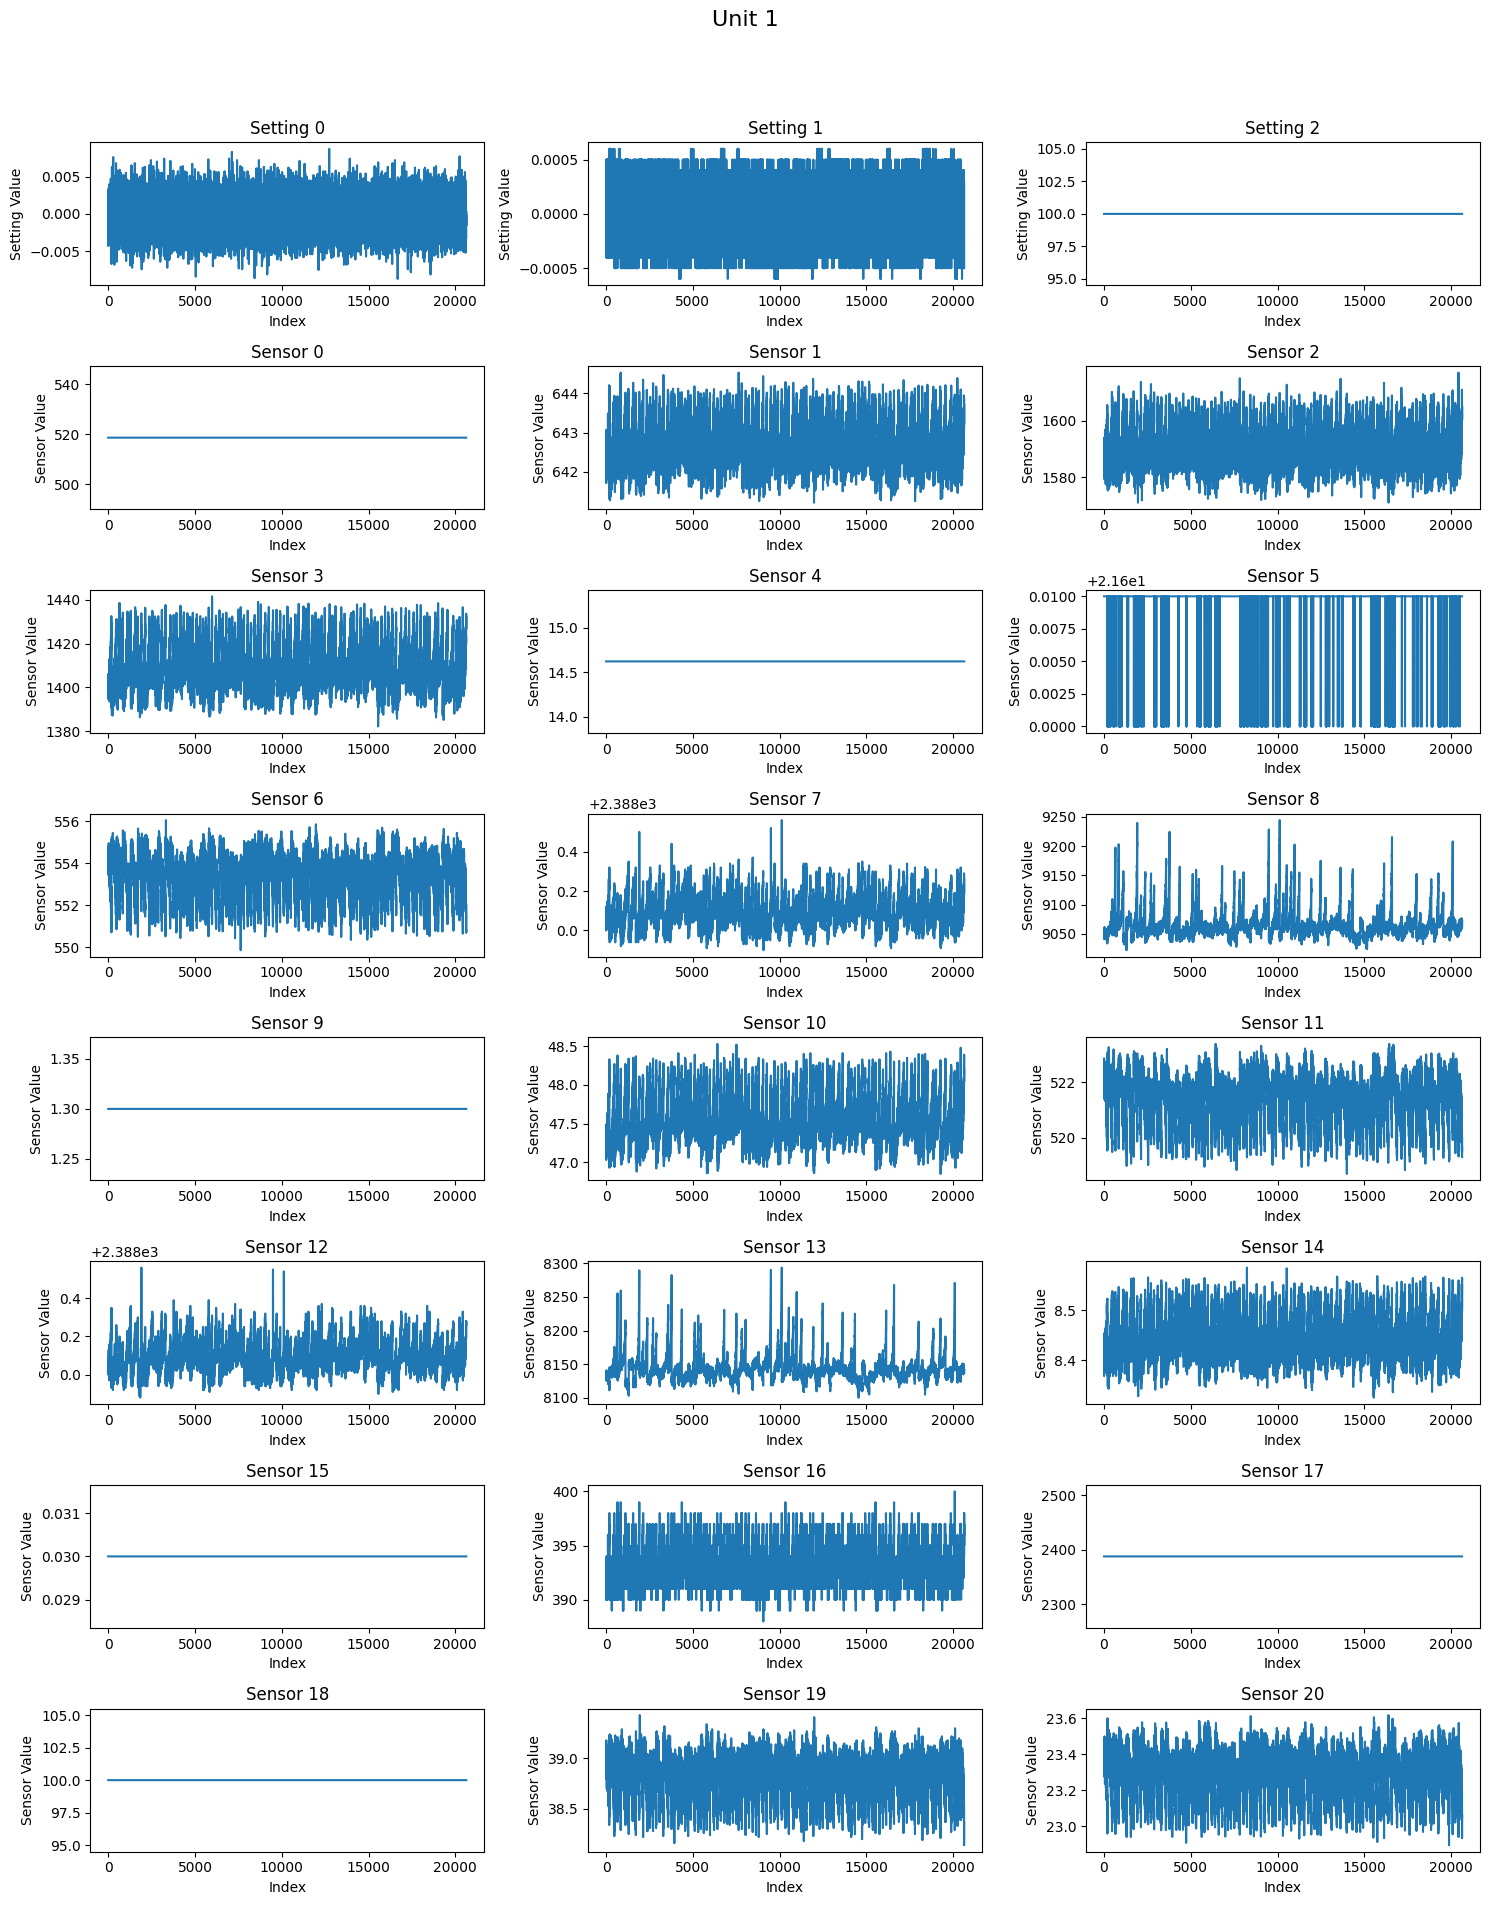

In [5]:
data_train["Index_Column"] = range(1, len(data_train) + 1)

#plot all attributes against the index column
fig, axs = plt.subplots(8, 3, figsize=(15, 20)) 
fig.suptitle('Unit ' + str(1), fontsize=16)
for j in range(3):
    row, col = divmod(j, 3)
    axs[row, col].plot(data_train['Index_Column'],
                       data_train['setting' + str(j)])
    axs[row, col].set_title('Setting ' + str(j))
    axs[row, col].set_xlabel('Index')
    axs[row, col].set_ylabel('Setting Value')

for k in range(21):
    row, col = divmod((k+3), 3)
    axs[row, col].plot(data_train['Index_Column'],
                       data_train['sensor' + str(k)])
    axs[row, col].set_title('Sensor ' + str(k))
    axs[row, col].set_xlabel('Index')
    axs[row, col].set_ylabel('Sensor Value')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

This tells us some sensor and settings values are constant for all units, and is hence not interesting for the training. These will be removed in a later stage!

##5) Plot the data for a single unit

  0%|          | 0/1 [00:00<?, ?it/s]

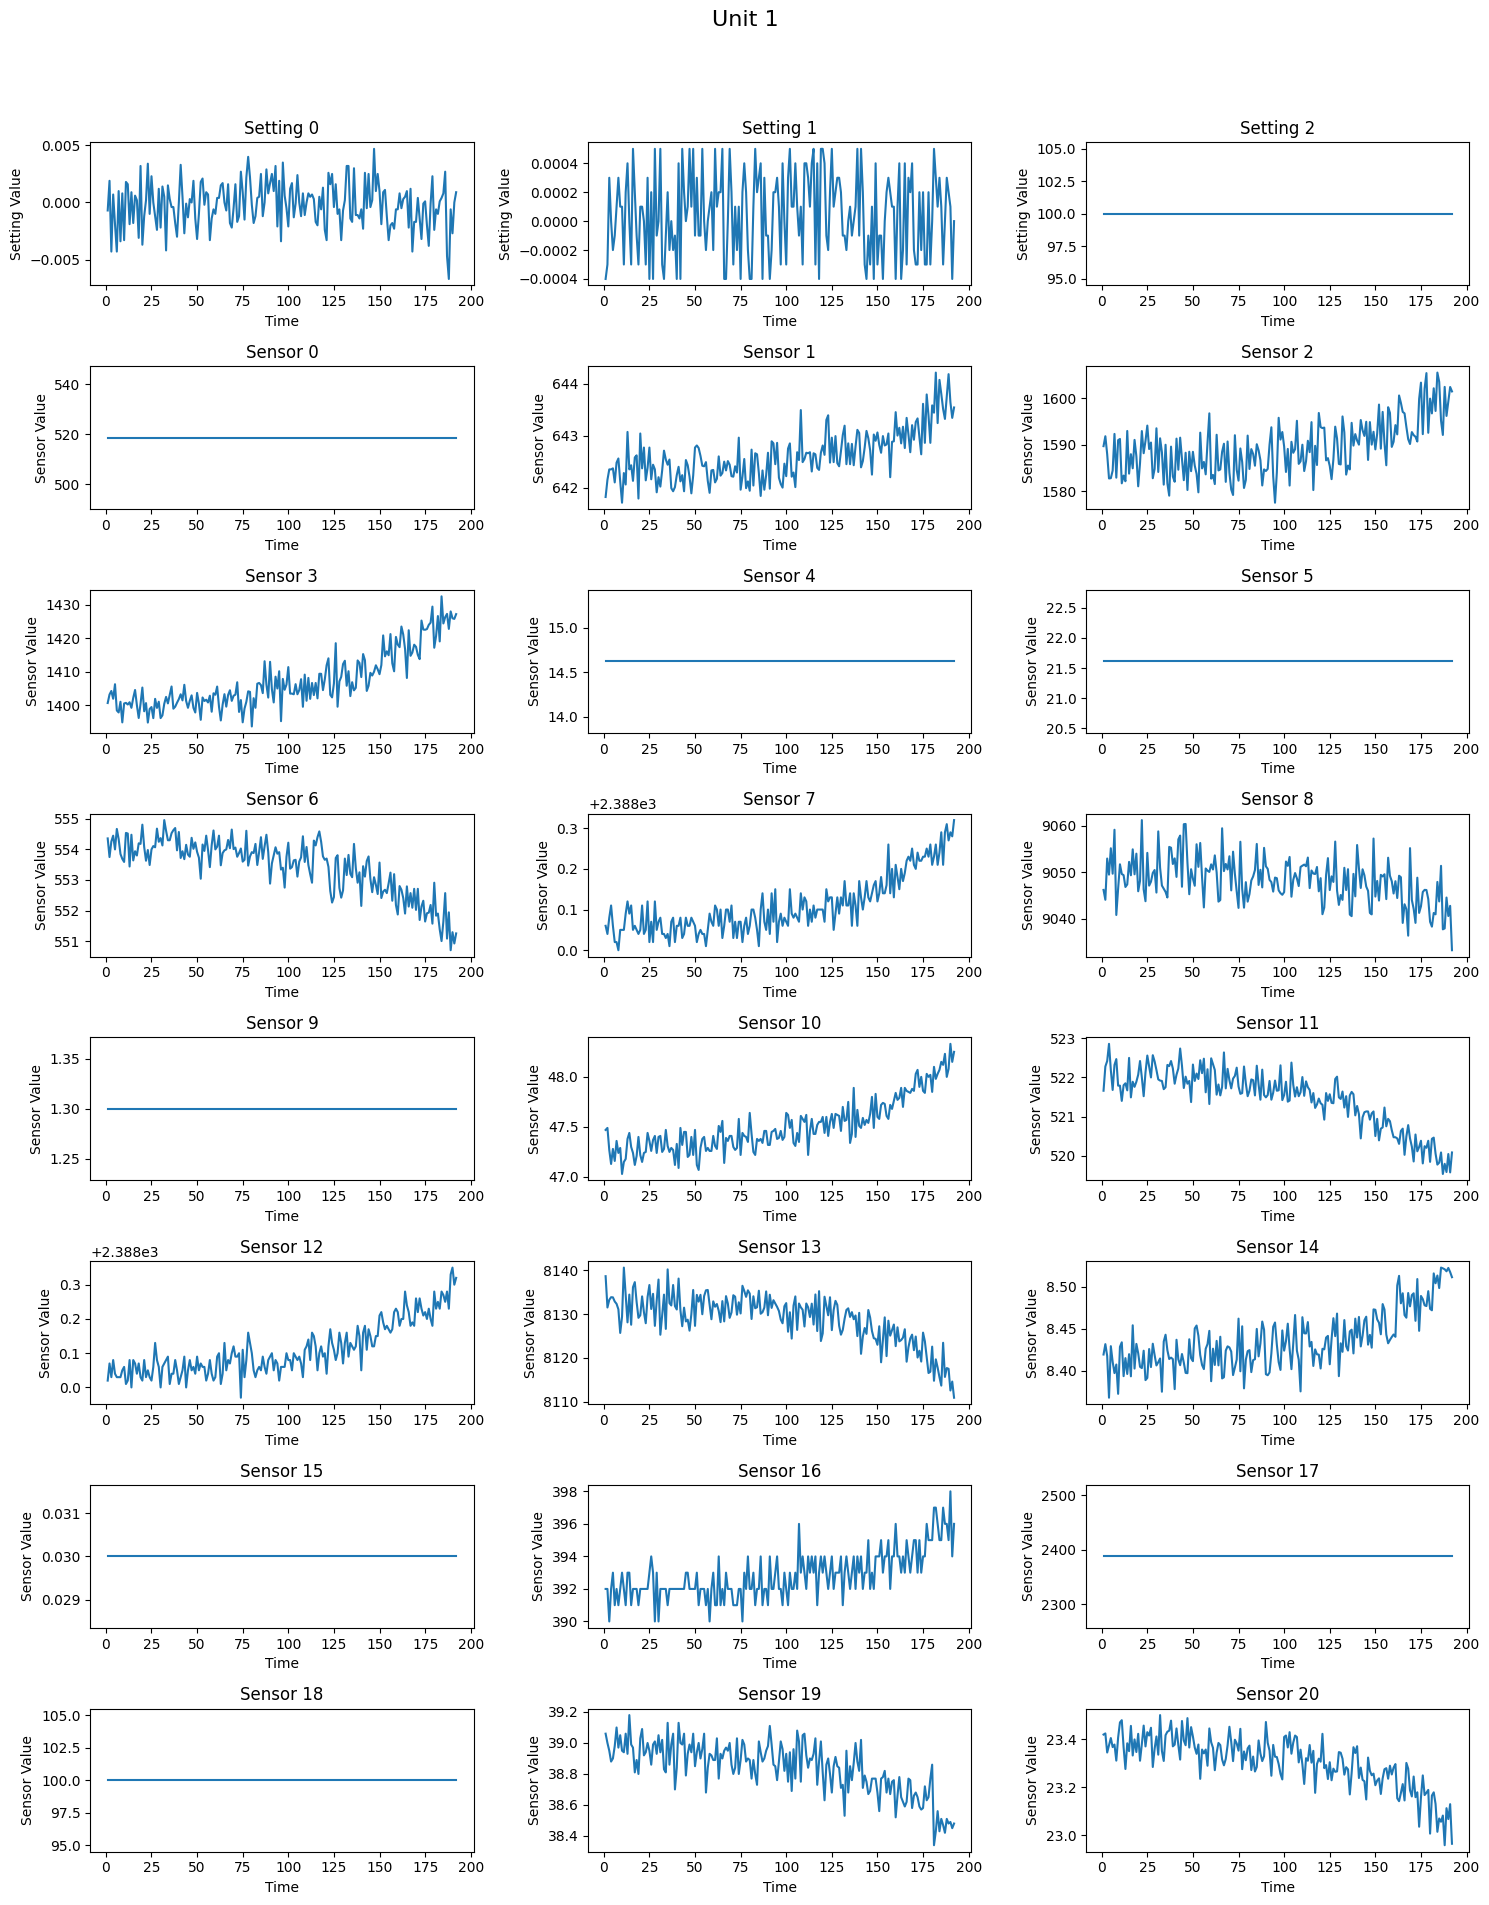

100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


In [6]:
#plot the input data for all units

#To plot several or different Units simply change the range in the for loop
for i in tqdm(range(1, 2)):
    fig, axs = plt.subplots(8, 3, figsize=(15, 20)) 
    fig.suptitle('Unit ' + str(i), fontsize=16)
    for j in range(3):
        row, col = divmod(j, 3)
        axs[row, col].plot(data_train[data_train.unit == i]['time'],
                           data_train[data_train.unit == i]['setting' + str(j)])
        axs[row, col].set_title('Setting ' + str(j))
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Setting Value')

    for k in range(21):
        row, col = divmod((k+3), 3)
        axs[row, col].plot(data_train[data_train.unit == i]['time'],
                           data_train[data_train.unit == i]['sensor' + str(k)])
        axs[row, col].set_title('Sensor ' + str(k))
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Sensor Value')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

##6) Drop irrelevant columns and normalize the training data

In [7]:
#training data set without labels
data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

#choose which columns of data you want to keep and which you want to drop.
#Training with everything works but might not be the best choice.

drop_list = ["setting2","sensor0", "sensor4", "sensor9", "sensor15", "sensor17", "sensor18"]
data_train = data_train.drop(drop_list, axis=1)

In [8]:
#normalization of the training data
#...
#data_train_scaled =
#columns = data_train_scaled.shape[1]

#Save and remove columns not to be normalized
units_and_time = data_train[['unit', 'time']]
data_train_wo_unit_time = data_train.drop(['unit', 'time'], axis=1)

#Normalize
scaler = StandardScaler().fit(data_train_wo_unit_time)
data_train_norm_values = scaler.transform(data_train_wo_unit_time)

#conver back to dataframe
data_train_norm = pd.DataFrame(data_train_norm_values, columns=data_train_wo_unit_time.columns)
data_train_norm[["unit", "time"]] = units_and_time

data_train_norm.head()

,setting0,setting1,sensor1,sensor2,sensor3,sensor5,sensor6,sensor7,sensor8,sensor10,sensor11,sensor12,sensor13,sensor14,sensor16,sensor19,sensor20,unit,time
0,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,1,1
1,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,1,2
2,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,1,3
3,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,1,4
4,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,1,5


##7) Plot the normalized the training data for all units and a single unit

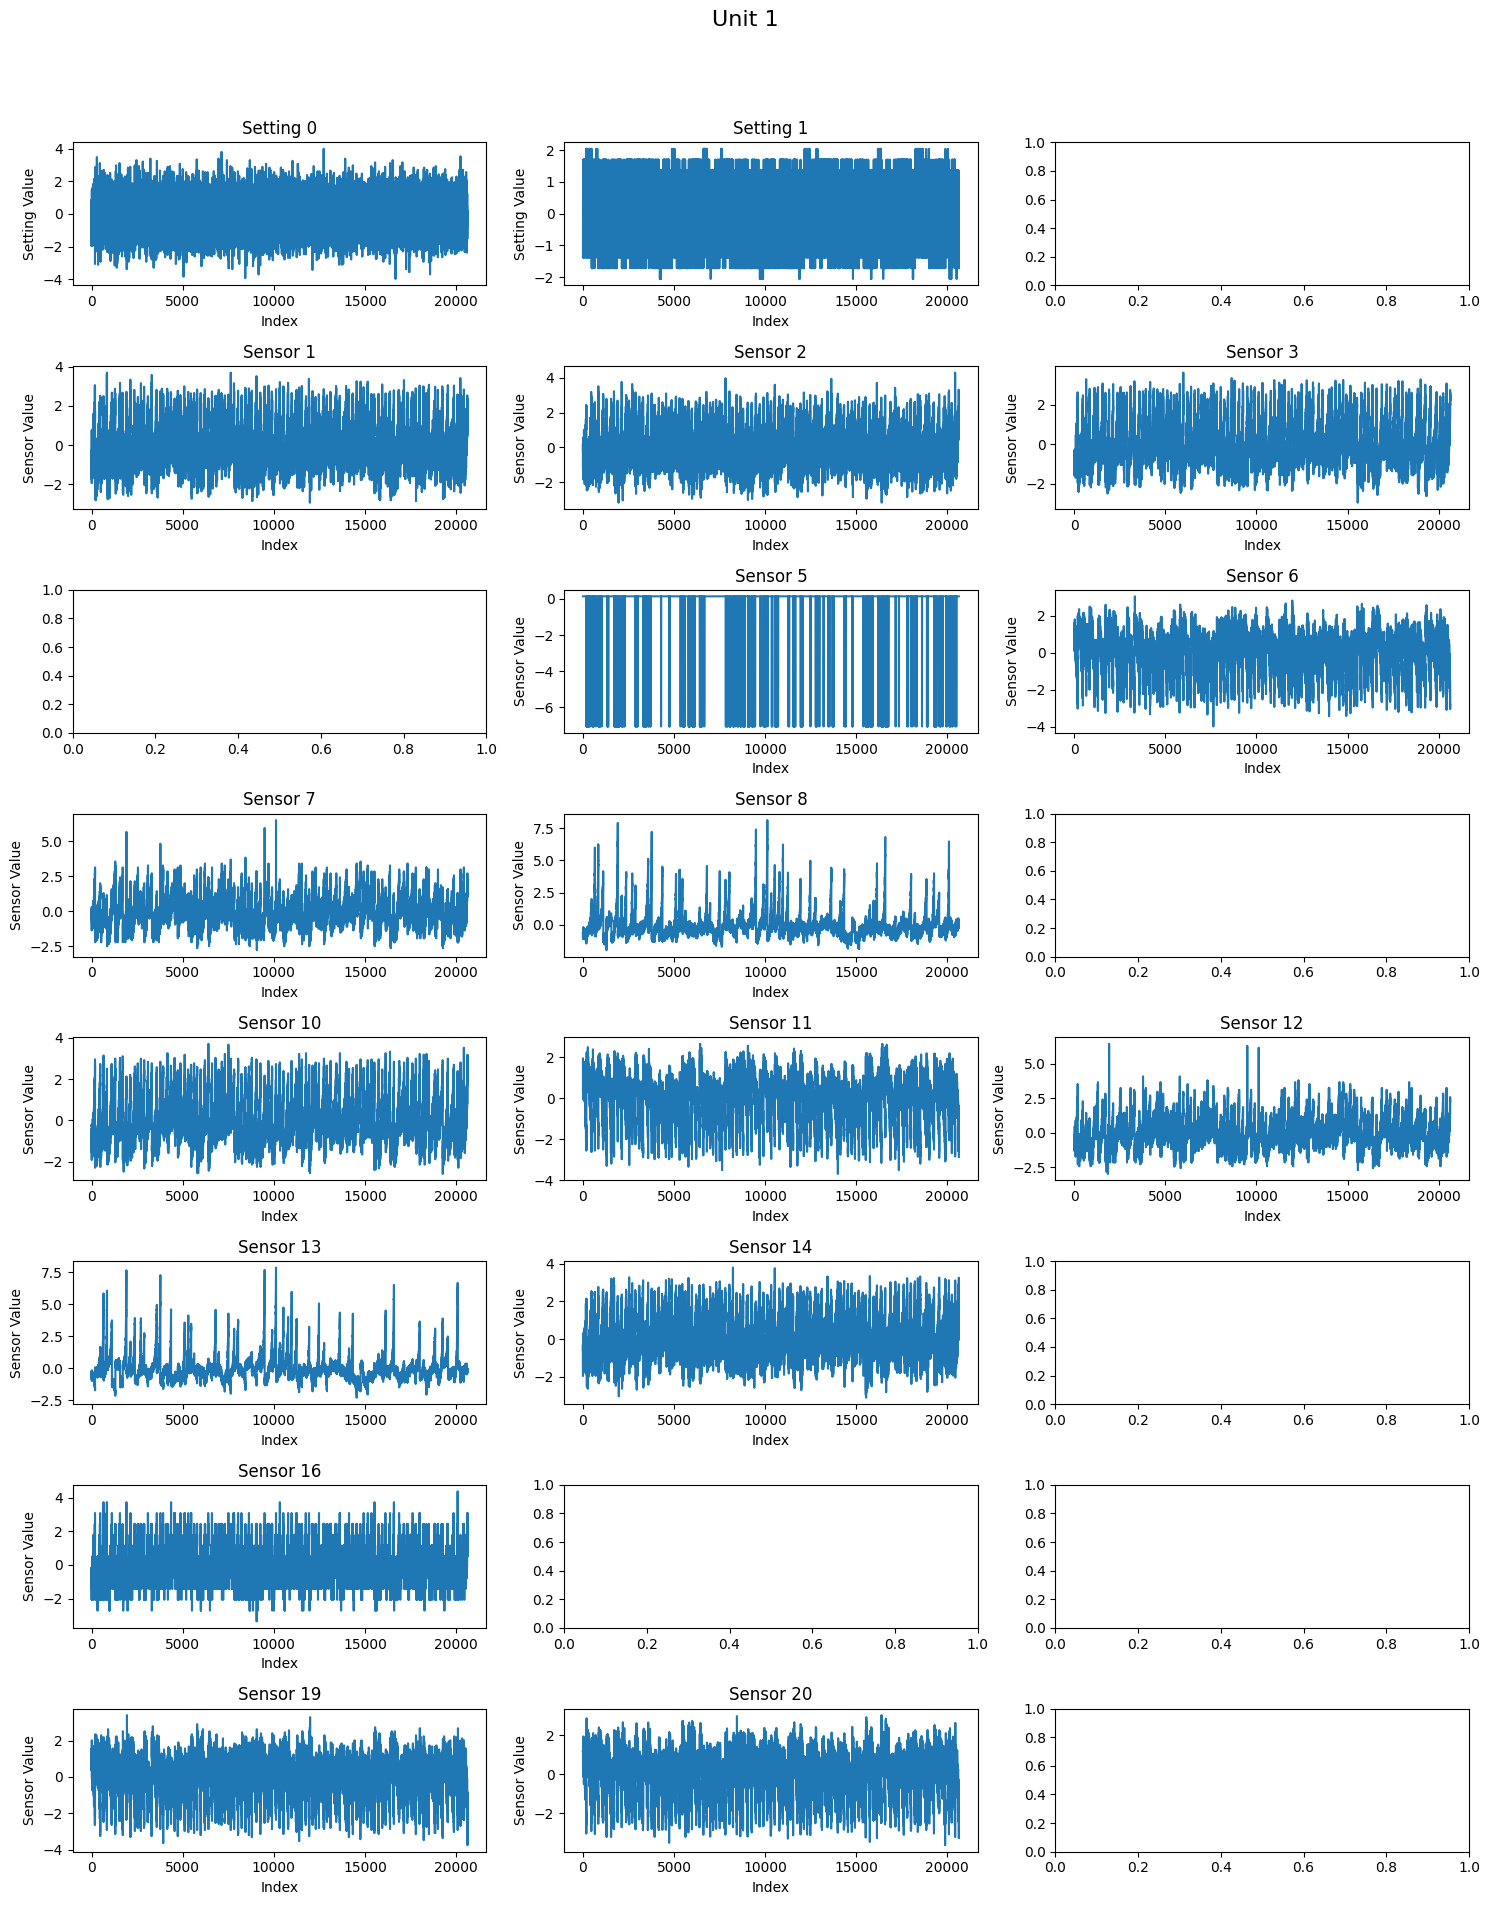

In [9]:
data_train_norm["Index_Column"] = range(1, len(data_train_norm) + 1)

#plot all attributes against the index column
fig, axs = plt.subplots(8, 3, figsize=(15, 20)) 
fig.suptitle('Unit ' + str(1), fontsize=16)
for j in range(2):
    row, col = divmod(j, 3)
    axs[row, col].plot(data_train_norm['Index_Column'],
                       data_train_norm['setting' + str(j)])
    axs[row, col].set_title('Setting ' + str(j))
    axs[row, col].set_xlabel('Index')
    axs[row, col].set_ylabel('Setting Value')

for k in [1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 19, 20]:
    row, col = divmod((k+2), 3)
    axs[row, col].plot(data_train_norm['Index_Column'],
                       data_train_norm['sensor' + str(k)])
    axs[row, col].set_title('Sensor ' + str(k))
    axs[row, col].set_xlabel('Index')
    axs[row, col].set_ylabel('Sensor Value')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

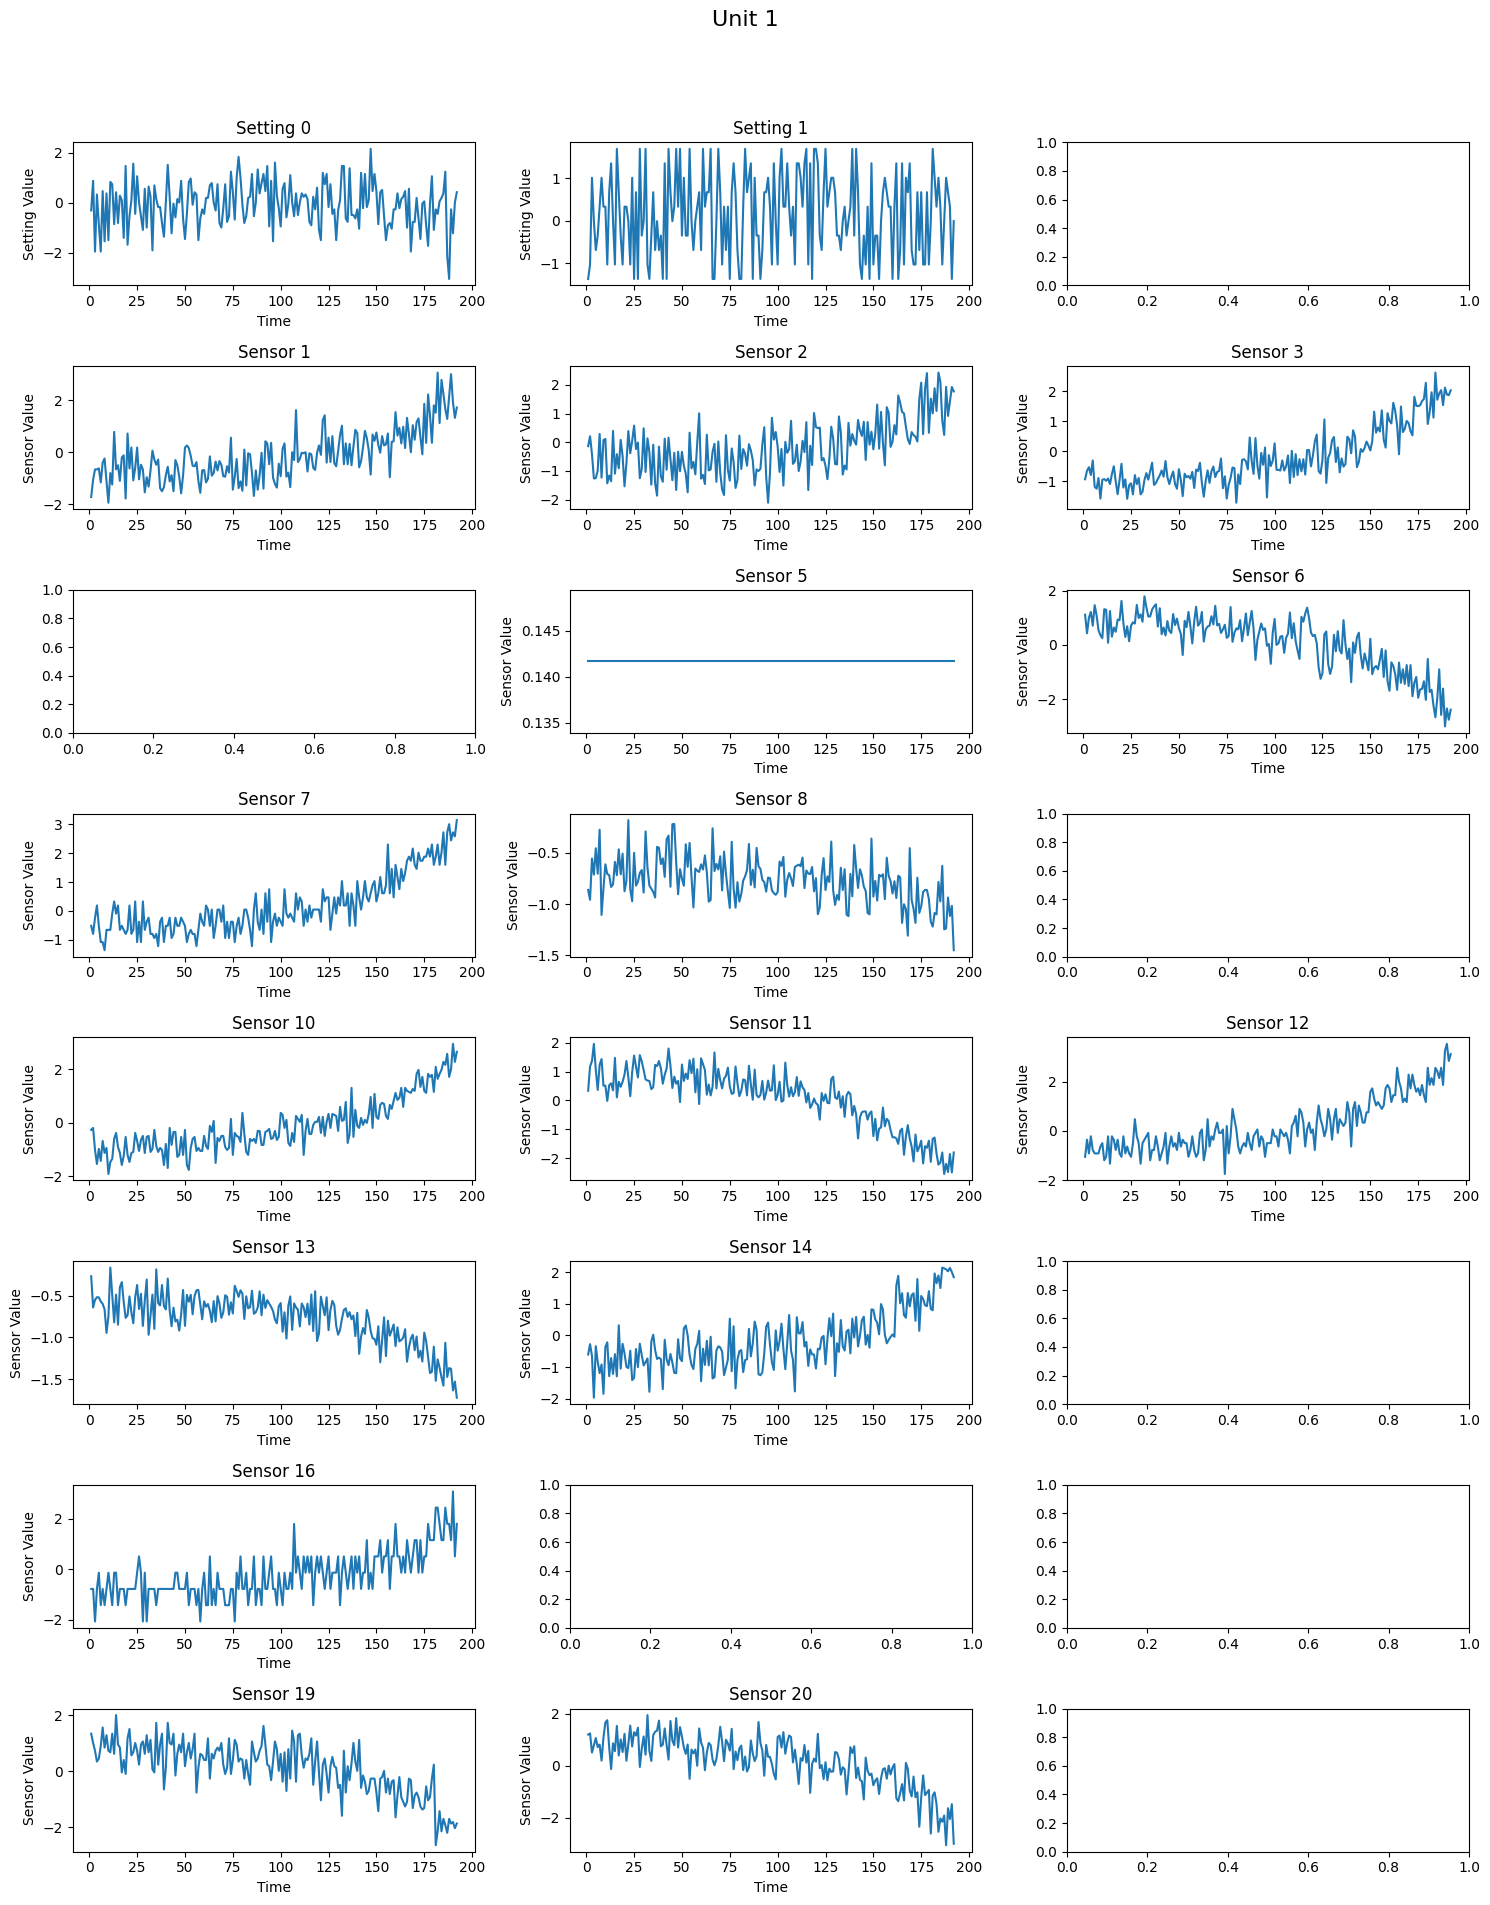

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


In [10]:
#plot the input data for all units
#To plot several or different Units simply change the range in the for loop
for i in tqdm(range(1, 2)):
    fig, axs = plt.subplots(8, 3, figsize=(15, 20)) 
    fig.suptitle('Unit ' + str(i), fontsize=16)
    for j in range(2):
        row, col = divmod(j, 3)
        axs[row, col].plot(data_train_norm[data_train_norm.unit == i]['time'],
                           data_train_norm[data_train_norm.unit == i]['setting' + str(j)])
        axs[row, col].set_title('Setting ' + str(j))
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Setting Value')

    for k in [1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 19, 20]:
        row, col = divmod((k+2), 3)
        axs[row, col].plot(data_train_norm[data_train_norm.unit == i]['time'],
                           data_train_norm[data_train_norm.unit == i]['sensor' + str(k)])
        axs[row, col].set_title('Sensor ' + str(k))
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Sensor Value')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 8) Preparing the labels for the training data

In [11]:
#calculate the RUL per time step (labels for training)
# you don't have to touch this

data_numpy = np.genfromtxt('train_FD001.txt')

engine_time = []

for i in range(len(data_numpy)):
  if data_numpy[i, 0] != data_numpy[i-1, 0]:
      time_steps_data = []
      engine_time.append(time_steps_data)
  time_steps_data.append(data_numpy[i, 1])

engine_RUL = []

for i in range(len(engine_time)):
  rul_new_data = np.array(engine_time[i])
  engine_RUL += list(np.flip(rul_new_data))

label_train = pd.DataFrame(engine_RUL)
label_train.columns = ['RUL']

print(label_train.shape)

(20631, 1)


In [12]:
label_train_ref = label_train.copy()
label_train_ref[["unit", "time"]] = units_and_time
print(label_train.head())
print(label_train_ref.head())

     RUL
0  192.0
1  191.0
2  190.0
3  189.0
4  188.0
     RUL  unit  time
0  192.0     1     1
1  191.0     1     2
2  190.0     1     3
3  189.0     1     4
4  188.0     1     5


##9) Plot cycle time and RUL for all units

  0%|          | 0/1 [00:00<?, ?it/s]

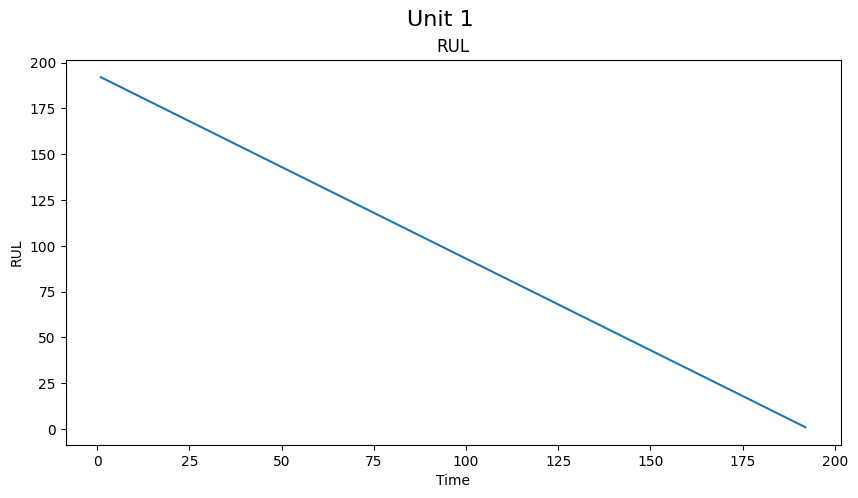

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


In [13]:
#plot the labels of the training data set
#To plot several or different Units simply change the range in the for loop
for i in tqdm(range(1, 2)):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Unit ' + str(i), fontsize=16)
    axs.plot(label_train_ref[label_train_ref.unit == i]['time'],
              label_train_ref[label_train_ref.unit == i]['RUL'])
    axs.set_title('RUL')
    axs.set_xlabel('Time')
    axs.set_ylabel('RUL')
    plt.show()

## 10) Creating time series samples

In [14]:
data_train_norm.head()

,setting0,setting1,sensor1,sensor2,sensor3,sensor5,sensor6,sensor7,sensor8,sensor10,sensor11,sensor12,sensor13,sensor14,sensor16,sensor19,sensor20,unit,time,Index_Column
0,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,1,1,1
1,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,1,2,2
2,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,1,3,3
3,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,1,4,4
4,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,1,5,5


In [15]:
#Removed time and index column for training data
data_train_scaled = data_train_norm[["unit","setting0", "setting1", "sensor1", "sensor2", "sensor3", "sensor5", "sensor6", "sensor7", "sensor8", "sensor10", "sensor11", "sensor12", "sensor13", "sensor14", "sensor16", "sensor19", "sensor20"]].values
print(data_train_scaled.shape)
print(data_train_scaled[0:2])

(20631, 18)
[[ 1.         -0.31597968 -1.3729532  -1.72172539 -0.13425518 -0.92593596
   0.14168333  1.12114057 -0.51633841 -0.86281332 -0.2664666   0.33426184
  -1.05889024 -0.26907104 -0.6038157  -0.78170979  1.34849274  1.19442705]
 [ 1.          0.87272193 -1.03172035 -1.06177971  0.21152849 -0.64372587
   0.14168333  0.43193018 -0.798093   -0.95881761 -0.19158293  1.17489932
  -0.363646   -0.64284474 -0.27585181 -0.78170979  1.01652793  1.23692196]]


In [16]:
#creating time series samples with length n_past to predict the RUL n_future steps in the future

trainX = []
trainY = []

n_future = 1
n_past = 10

for i in range(n_past, len(data_train_scaled) - n_future +1):
    if data_train_norm.iloc[i - n_past]["unit"] == data_train_norm.iloc[i]["unit"]:
        trainX.append(data_train_scaled[i - n_past:i, 0:data_train_scaled.shape[1]])
        trainY.append(label_train[i + n_future - 1:i + n_future])

trainX_all, trainY_all = np.array(trainX), np.array(trainY)[:,0]

print('trainX shape == {}.'.format(trainX_all.shape))
print('trainY shape == {}.'.format(trainY_all.shape))

trainX shape == (19631, 10, 18).
trainY shape == (19631, 1).


In [17]:
print(trainX_all[0])
print(trainY_all[0]) 

[[ 1.         -0.31597968 -1.3729532  -1.72172539 -0.13425518 -0.92593596
   0.14168333  1.12114057 -0.51633841 -0.86281332 -0.2664666   0.33426184
  -1.05889024 -0.26907104 -0.6038157  -0.78170979  1.34849274  1.19442705]
 [ 1.          0.87272193 -1.03172035 -1.06177971  0.21152849 -0.64372587
   0.14168333  0.43193018 -0.798093   -0.95881761 -0.19158293  1.17489932
  -0.363646   -0.64284474 -0.27585181 -0.78170979  1.01652793  1.23692196]
 [ 1.         -1.96187421  1.01567674 -0.66181262 -0.41316559 -0.52595315
   0.14168333  1.00815526 -0.23458381 -0.55713925 -1.0153033   1.36472069
  -0.91984139 -0.55162928 -0.64914404 -2.07309423  0.73989059  0.50342281]
 [ 1.          0.32409042 -0.00802181 -0.66181262 -1.26131421 -0.78483092
   0.14168333  1.22282735  0.18804808 -0.71382551 -1.53948899  1.96130213
  -0.22459715 -0.52017567 -1.97166509 -0.78170979  0.3525983   0.77779214]
 [ 1.         -0.86461119 -0.69048751 -0.62181592 -1.25152788 -0.30151835
   0.14168333  0.71439345 -0.51633

## 11) Preparing the test data

In [18]:
#test data set without labels

data_test = pd.read_csv('test_FD001.txt', delimiter=' ', header=None)

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))
name_list.append('empty1')
name_list.append('empty2')
data_test.columns = name_list

data_test = data_test.drop(['empty1'], axis=1)
data_test = data_test.drop(['empty2'], axis=1)

##############################################
#drop the unneccesary columns
#data_test = data_test.drop(['xxx'], axis=1)
data_test = data_test.drop(drop_list, axis=1)

#normalization of the test data
#...
#data_test_scaled=

#Save and remove columns not to be normalized
units_test = data_test[['unit']]
data_test_wo_unit = data_test.drop(['unit', "time"], axis=1)

#Normalize
scaler = StandardScaler().fit(data_test_wo_unit)
data_test_norm_values = scaler.transform(data_test_wo_unit)

#conver back to dataframe
data_test_norm = pd.DataFrame(data_test_norm_values, columns=data_test_wo_unit.columns)
data_test_norm.insert(0, "unit", units_test["unit"])

data_test_scaled = data_test_norm.values

##############################################
columns = data_test_scaled.shape[1]

data_test_list = []
time_steps_data = np.empty((2, columns))

for i in range(len(data_test_scaled)):

  if i == len(data_test_scaled)-1:
    data_test_list.append(time_steps_data)

  elif data_test_scaled[i, 0] != data_test_scaled[i-1, 0]:
    time_steps_data = time_steps_data[1:]
    data_test_list.append(time_steps_data)
    time_steps_data = np.empty(columns)

  time_steps_data = np.vstack((time_steps_data, data_test_scaled[i]))
data_test_list = data_test_list[1:]

print('data_test_list length == {}.'.format(len(data_test_list)))
print('data_test_list first element shape == {}.'.format(data_test_list[0].shape))

data_test_list length == 100.
data_test_list first element shape == (31, 18).


In [19]:
print(data_test_list[0:2])

[array([[ 1.        ,  1.04929536,  1.00592724,  1.35927635, -0.56149466,
        -0.97567424,  0.17565996,  0.20913759, -0.53907794, -0.72031219,
        -1.10359065, -0.04954158, -0.72059021, -1.31503071, -0.71165923,
        -0.46340588, -0.22940849,  0.44886618],
       [ 1.        , -1.22074812, -1.03475484, -1.90850157,  0.0701159 ,
        -1.39283595,  0.17565996,  1.60361233, -1.06136579, -0.34867303,
         0.42772659,  0.73672677, -0.19364705,  0.06597653, -1.57003662,
         0.34727584,  0.89993409,  0.66404249],
       [ 1.        ,  0.14127797,  0.32569988, -0.03763635, -0.23169801,
        -0.50767562,  0.17565996,  0.5173899 , -0.364982  , -0.12656397,
         0.42772659,  0.3972018 , -0.72059021, -0.86843633,  0.62933997,
         0.34727584,  1.32343755,  0.96124733],
       [ 1.        ,  1.91191188, -0.0144138 , -0.08752609, -0.79535047,
         0.25188763,  0.17565996,  0.45867517, -0.71317389, -1.14704139,
        -0.69523938, -0.65711257, -0.36929477, -0.59

## 12) Preparing the labels for the test data

In [20]:
#test labels at the end of the series of each unit
# you don't have to touch this

label_test = pd.read_csv('RUL_FD001.txt', delimiter=' ', header=None)

name_list = ['RUL_final', 'empty']
label_test.columns = name_list
label_test = label_test.drop(['empty'], axis=1)

label_test_array = np.array(label_test)[:,0]

print('label_test shape == {}.'.format(label_test.shape))
print('label_test_array shape == {}.'.format(label_test_array.shape))

label_test shape == (100, 1).
label_test_array shape == (100,).


In [21]:
print(label_test)

    RUL_final
0         112
1          98
2          69
3          82
4          91
..        ...
95        137
96         82
97         59
98        117
99         20

[100 rows x 1 columns]


## 13) Define the RNN

In [23]:
#Define the LSTM architecture

last_layer = 1

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(trainX_all.shape[1], trainX_all.shape[2])))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(last_layer, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               75264     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 85633 (334.50 KB)
Trainable params: 85633 (334.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 14) Train the RNN

In [24]:
#Define callbacks to save the best model during the training

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
#keras.callbacks.ReduceLROnPlateau(factor=, patience=, verbose=, min_lr=),
#keras.callbacks.EarlyStopping(patience=, verbose=)
#keras.callbacks.ModelCheckpoint("best_model.hdf5", save_best_only=True, monitor=, mode=)
results = model.fit(trainX_all, trainY_all,
    epochs=40,
    batch_size=64,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor="val_loss", restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("best_model.hdf5".format(model.name), save_best_only=True, monitor="val_loss")])

Epoch 1/40
246/246 [==============================] - 6s 14ms/step - loss: 3201.1216 - mae: 39.1589 - val_loss: 2936.5530 - val_mae: 38.6292 - lr: 0.0010
Epoch 2/40
 12/246 [>.............................] - ETA: 2s - loss: 1250.1644 - mae: 25.1675

c:\Users\pontu\anaconda3\envs\AIIA\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 3s 11ms/step - loss: 1138.7991 - mae: 23.8341 - val_loss: 3519.0938 - val_mae: 41.4212 - lr: 0.0010
Epoch 3/40
246/246 [==============================] - 3s 11ms/step - loss: 987.3673 - mae: 22.0882 - val_loss: 3707.1470 - val_mae: 42.4184 - lr: 0.0010
Epoch 4/40
246/246 [==============================] - ETA: 0s - loss: 871.2225 - mae: 20.7995
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
246/246 [==============================] - 3s 12ms/step - loss: 871.2225 - mae: 20.7995 - val_loss: 3877.2351 - val_mae: 43.7256 - lr: 0.0010
Epoch 5/40
246/246 [==============================] - 3s 12ms/step - loss: 711.5817 - mae: 18.7497 - val_loss: 3488.7563 - val_mae: 42.0867 - lr: 6.7000e-04
Epoch 6/40
246/246 [==============================] - 4s 14ms/step - loss: 639.8690 - mae: 17.6438 - val_loss: 4526.9263 - val_mae: 47.6943 - lr: 6.7000e-04
Epoch 7/40
244/246 [============================>.] - ETA: 0s - loss: 592.4268

## 15) Plot the results and Evaluate the performance

In [ ]:
# Extract unit numbers from the first column of each array
unit_numbers = trainX_all[:, :, 0]

# Initialize dictionaries to store the first and last indices of each unit
first_indices = {}
last_indices = {}

# Iterate through the dataset
for i in range(len(trainX_all)):
        unit_number = int(unit_numbers[i, 0])

        # Update the first index if it's not set yet
        if unit_number not in first_indices:
            first_indices[unit_number] = (i)

        # Always update the last index to keep it current
        last_indices[unit_number] = (i)

# Print the first and last indices for each unit
for unit_number, first_index in first_indices.items():
    last_index = last_indices[unit_number]
    print(f"Unit {unit_number}: First Index {first_index}, Last Index {last_index}")

#print first and last index of unit 3
print(first_indices[3])
print(last_indices[3])

Unit 1: First Index 0, Last Index 181
Unit 2: First Index 182, Last Index 458
Unit 3: First Index 459, Last Index 627
Unit 4: First Index 628, Last Index 806
Unit 5: First Index 807, Last Index 1065
Unit 6: First Index 1066, Last Index 1243
Unit 7: First Index 1244, Last Index 1492
Unit 8: First Index 1493, Last Index 1632
Unit 9: First Index 1633, Last Index 1823
Unit 10: First Index 1824, Last Index 2035
Unit 11: First Index 2036, Last Index 2265
Unit 12: First Index 2266, Last Index 2425
Unit 13: First Index 2426, Last Index 2578
Unit 14: First Index 2579, Last Index 2748
Unit 15: First Index 2749, Last Index 2945
Unit 16: First Index 2946, Last Index 3144
Unit 17: First Index 3145, Last Index 3410
Unit 18: First Index 3411, Last Index 3595
Unit 19: First Index 3596, Last Index 3743
Unit 20: First Index 3744, Last Index 3967
Unit 21: First Index 3968, Last Index 4152
Unit 22: First Index 4153, Last Index 4344
Unit 23: First Index 4345, Last Index 4502
Unit 24: First Index 4503, Last

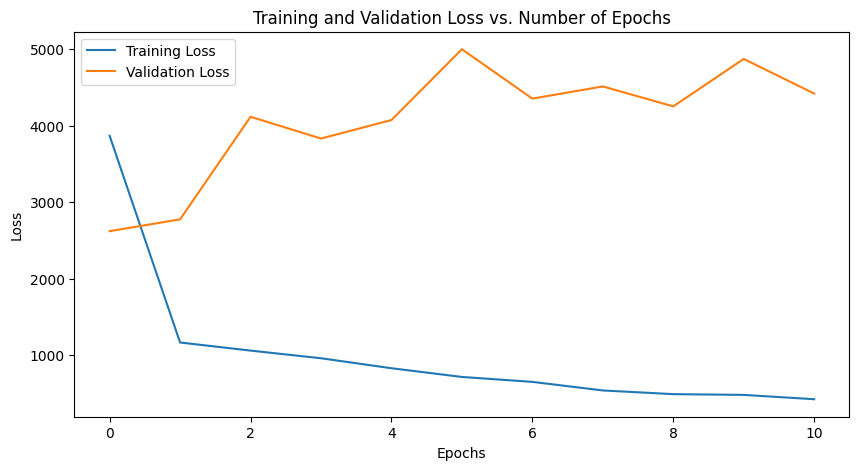

In [ ]:
#Plotting training loss and validation loss
history = results.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Testing on the training set to predict the RUL
def predict_RUL(model, unit):
    """
    Predict the next n_future steps in the future
    """
    #unit_first_index = data_train[data_train.unit == unit].index[0]
    #unit_last_index = data_train[data_train.unit == unit].index[-1]
    
    predicted_RULs = []
    for i in tqdm(range(first_indices[unit] , last_indices[unit] + 1)):
        prediction = model.predict(trainX_all[i].reshape(1, trainX_all.shape[1], trainX_all.shape[2]), verbose = 0)
        predicted_RULs.append(prediction.flatten()[0])
    return predicted_RULs

In [ ]:
#Plotting the true RUL and the network prediction for the training data set

def plot_prediction(model, unit):
    predicted_RUL = predict_RUL(model, unit)

    plt.figure(figsize=(12,4))
    plt.plot(predicted_RUL, label='Predicted RUL')
    #plt.plot(predicted_RUL, label='Predicted RUL')
    plt.plot(trainY_all[first_indices[unit]:last_indices[unit]], label='True RUL')
    plt.title('True and Predicted RULs  vs. Time for Unit ' + str(unit))
    plt.xlim(0, last_indices[unit]-first_indices[unit])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('RUL')
    plt.show()

100%|██████████| 259/259 [00:16<00:00, 15.36it/s]


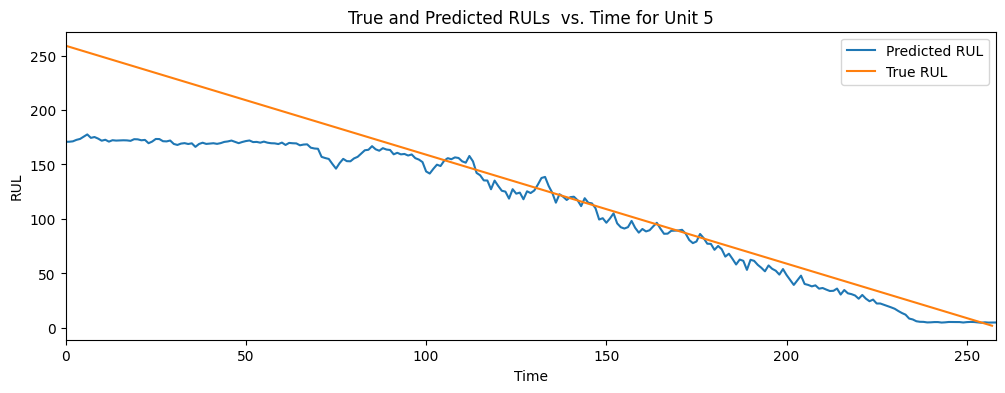

In [ ]:
plot_prediction(model = model, unit = 5)

In [ ]:
#Testing on the n_past last samples of the test set to predict the RUL
#you can load the best model of your callback option via
#model.load_weights("best_model.hdf5")
#print(data_test_norm.head())

model.load_weights("best_model.hdf5")

#For each array in data_test_list, select the last n_past data points
n_last_data = [array[-n_past:] for array in data_test_list]

#Convert the list of arrays to a numpy array for model prediction
last_five_data_array = np.array(n_last_data)

#Prediciton
test_predictions = model.predict(last_five_data_array)

print(test_predictions)

4/4 [==============================] - 0s 5ms/step
[[116.54361  ]
 [ 69.47134  ]
 [  5.7168813]
 [ 18.268251 ]
 [ 38.88712  ]
 [ 62.918125 ]
 [ 68.56659  ]
 [ 43.61989  ]
 [ 74.77319  ]
 [ 57.025707 ]
 [ 46.262283 ]
 [ 53.17317  ]
 [ 46.58346  ]
 [ 76.57182  ]
 [112.02074  ]
 [ 85.27878  ]
 [ 24.528084 ]
 [ 25.742924 ]
 [ 89.003006 ]
 [  6.298759 ]
 [ 40.76402  ]
 [122.036896 ]
 [129.73006  ]
 [  9.55676  ]
 [127.03093  ]
 [ 87.69726  ]
 [119.084724 ]
 [ 52.889854 ]
 [ 55.17308  ]
 [ 40.67835  ]
 [  6.077211 ]
 [ 33.711872 ]
 [ 50.7115   ]
 [  5.8674827]
 [  5.716436 ]
 [  7.0342846]
 [ 27.986174 ]
 [ 13.1901045]
 [125.027115 ]
 [  7.470218 ]
 [ 29.385983 ]
 [  7.226916 ]
 [ 29.75853  ]
 [104.54961  ]
 [ 22.763397 ]
 [ 13.114658 ]
 [ 77.87987  ]
 [ 96.981064 ]
 [  6.488303 ]
 [ 80.14449  ]
 [ 90.623184 ]
 [ 17.738811 ]
 [ 11.9030695]
 [129.75887  ]
 [109.02002  ]
 [  7.4534926]
 [ 50.656612 ]
 [ 14.368939 ]
 [135.06616  ]
 [ 71.080734 ]
 [ 10.340541 ]
 [ 24.885456 ]
 [ 35.73057  ]
 [ 1

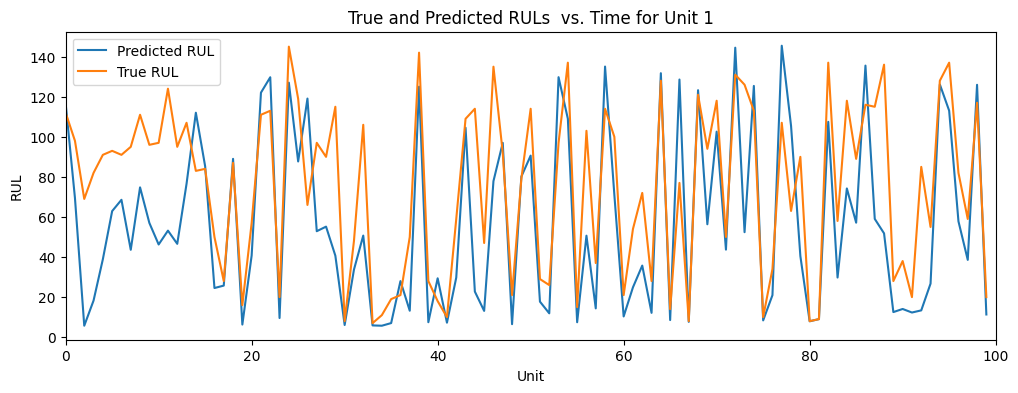

In [ ]:
#Plotting the prediction and the true values for each unit
#Hint: It's easier to compare the true values and the predicted values if you order them in a smart way.

#plot test_predictions together with label_test
plt.figure(figsize=(12,4))
plt.plot(test_predictions, label='Predicted RUL')
plt.plot(label_test_array, label='True RUL')
plt.title('True and Predicted RULs  vs. Time for Unit ' + str(unit))
plt.xlim(0, 100)
plt.legend()
plt.xlabel('Unit')
plt.ylabel('RUL')
plt.show()


In [ ]:
#calculate the MSE of the two arrays
print(mean_squared_error(label_test_array, test_predictions))

1137.0462650996797


##16) Recommend Maintenance

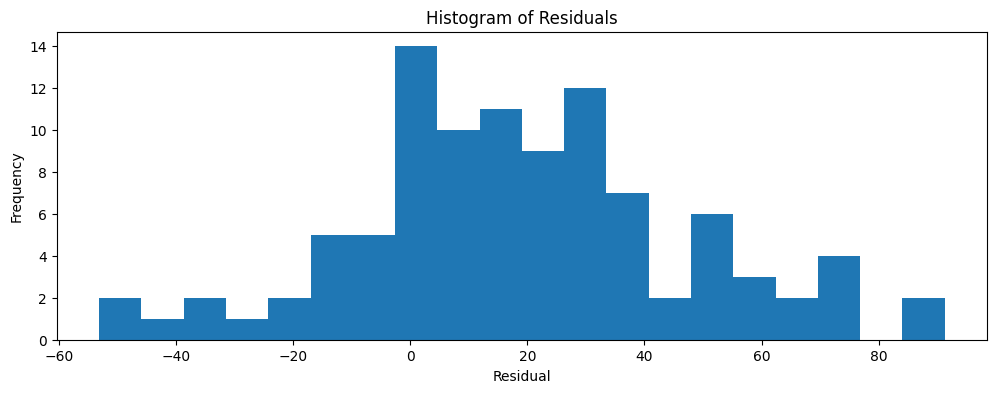

In [ ]:
#Plotting the residuals in a histogram and determine the standard diviation

#Calculate the residuals
residuals = label_test_array - test_predictions.flatten()

#Plot the residuals in a histogram
plt.figure(figsize=(12,4))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#answer to question 10:

output_for_maint = 2*np.std(residuals) + 20
print('The engine should be recomended for maintainance with an output below: ', output_for_maint)

The engine should be recomended for maintainance with an output below:  76.45082674544548
